# A/B Testing Case Study for a Video Streaming Company

In this Jupyter Notebook I will conduct an A/B test for a hypothetical video streaming company who is testing new artworks designs for shows in their catalogue. I will detail the steps that I make to produce an in depth guide to A/B testing. I will be using fake data that I have generated myself, but will try to make the exercise as real as possible by tying the insights and outcomes to real life results and solutions.

In [1]:
# Importing the packages we will need for the A/B test
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
# Setting some of the visualisation defaults and the random seed so that the same data can be reproduced
%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

np.random.seed(seed=6)

## Contents:

* Scenario
* Calculating the required sample size

## Scenario
A video streaming company is trying to increase the click through rate on shows suggested by its personalized recommendation engine. The company has recently designed new artwork covers for some shows and the goal of conducting this A/B test is to establish if there is a statistically significant change in click through rate between the current and new artworks. 

The company's current click through rate for the show is 4% and they would like to see an increase of 2%. Using these values we can calculate the effect size of our test which indicates how meaningful the difference between our values is in the case that we find the difference to be statistically significant.

In [3]:
# I have taken 4% and 2% as a standard industry click through rate for a video and desired click through rate increase
current_click_through_rate = 0.06
desired_difference = 0.02
desired_click_through_rate = current_click_through_rate + desired_difference

## Calculating the required sample size

To calculate the required sample size of users for our test we first calculate the effect size using the click through rates chosen earlier

In [4]:
# Calculating effect size based on our expected rates using Cohen's h test
effect_size = sms.proportion_effectsize(desired_click_through_rate, current_click_through_rate) 
'Our effect size is: {:.2f}'.format(effect_size)

'Our effect size is: 0.08'

The effect size was calculated using cohen's h test where an effect size of 0.2, 0.5 and 0.8 correspond to a small, medium and large effect respectively.

Thus our effect size of 0.08 (to 2 sig. fig.) would be categorised as a small effect, however Cohen does 
acknowledge that his categorisations should be taken with a pinch of salt and woulddepend on the industry and context of 
the situation.

If you are interested in finding out more about Cohen's h then I'd recommend the following links:

https://people.ucalgary.ca/~ramsay/cohen-effect-size-h-arcsin-transformation.htm

https://en.wikipedia.org/wiki/Cohen%27s_h

Out of interest I thought I'd calculate the required values for our desired click through rate to give a small, medium and large significance according to cohen's h test. 

In [5]:
# To calculate the conversion rates that would give small, medium and large effects according to cohen we use the below formula:
cohen_h_boundaries = {'Small':0.2,'Medium':0.5,'Large':0.8}
for p in cohen_h_boundaries.keys():
    print(p + ': ' + str(np.sin((np.arcsin(current_click_through_rate**(1/2)) + cohen_h_boundaries[p]/2))**2))

Small: 0.11595205767112275
Medium: 0.22772092978121017
Large: 0.3638116803184712


These values seem to large to suit click through rates for videos and so I am keen on exploring more suitable guidance systems for effect sizes in this area

Now that we have the effect size for the change in our click through rates we will use it to calculate the number of samples of our population that we need so that if there is an effect from the website change we will have a high chance (80% based on the power choice below) to detect it as statistically significant.

In [6]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

2543


From this calculation we can see that we'll require 2543 users in each sample group of users in order to have a high chance of detecting a statistically significant change. There are many practical implications to the number of sample users required. For example if the chances of a certain event occurring are especially low or the website has very little traffic then it might take a long time to get enough data for adequate testing and so it may become unreasonable to test it in this way. Alternative methods could be using focus groups and surveys.

We will conduct a two sided hypothesis test on our data where the null hypothesis is that the mean click through rate of the control and test group are the same and the alternative hypothesis is that they are not. Our alpha value for the test is 0.05 meaning that when we calculate our p value at the end of the test we will accept the null hypothsis if p>=0.05 and reject it if p < 0.05

Now we're gonna need some data. Let's generate some ourselves by creating two groups of users each of the size that we have calculated earlier. These groups will be our control and test groups where the control group will be using the current artwork for our video and the test group will be viewing the new one.

We will use the Bernoulli distribution to model the chance of each user clicking on the specific video when it comes up as recommended where the chance is equal to either the control or test click through rate. 

In [7]:
sample_size = required_n
control_click_through_rate = 0.06
test_click_through_rate = 0.07

In [8]:
def generate_data(sample_size, control_click_through_rate, test_click_through_rate, control_label='Control',
                  test_label='Test'):
    """Returns a pandas dataframe with fake conversion rate data
    Example:
    Parameters:
        sample_size (int): sample size for both control and test groups
        control_conversion_rate (float): conversion rate of control group
        test_conversion_rate (float): conversion rate of test group
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate bernoulli distributions from which to randomly sample
    control_bern = stats.bernoulli(control_click_through_rate)
    test_bern = stats.bernoulli(test_click_through_rate)
    
    # Create Data Frame of control and test cases based on the required sample size
    data = {'group':[control_label]*sample_size + [test_label]*sample_size}
    df = pd.DataFrame(data,columns=['group'])
    
    # Assign converted or not converted binary value to each case
    df['clicked'] = df['group'].apply(lambda x: control_bern.rvs() if x == control_label else test_bern.rvs())

    return df

In [9]:
ab_test = generate_data(sample_size, control_click_through_rate, test_click_through_rate, control_label='Control',
                  test_label='Test')

Below we have our simplified click through rate data. Here the 'group' column indicates whether the user was in the control or test group and the 'clicked' columns indicates whether the user clicked on the video or not, with a 1 representing a click.

In [10]:
ab_test

,group,clicked
0,Control,0
1,Control,0
2,Control,0
3,Control,0
4,Control,0
...,...,...
5081,Test,0
5082,Test,0
5083,Test,0
5084,Test,1


We will gain a preliminary understanding of our data through looking at various key aspects

In [11]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5086 entries, 0 to 5085
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   group    5086 non-null   object
 1   clicked  5086 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 79.6+ KB


In [12]:
ab_test.describe()

,clicked
count,5086.000000
mean,0.069799
std,0.254834
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [13]:
# Checking to see we are getting the correct proportion of our control and test groups
ab_test['group'].value_counts(ascending=False)

Test       2543
Control    2543
Name: group, dtype: int64

In [14]:
ab_test.value_counts(ascending=False)

group    clicked
Control  0          2390
Test     0          2341
         1           202
Control  1           153
dtype: int64

In [15]:
ab_test.groupby(['group'])['clicked'].mean()

group
Control    0.060165
Test       0.079434
Name: clicked, dtype: float64

In [16]:
std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

In [17]:
click_through_rates = ab_test.groupby('group')['clicked'].agg([len,np.sum,np.mean, std_p, se_p])
click_through_rates.columns = ['num_users','num_clicks','click_through_rate', 'std_deviation', 'std_error']
click_through_rates = click_through_rates.reset_index()

In [18]:
click_through_rates

,group,num_users,num_clicks,click_through_rate,std_deviation,std_error
0,Control,2543,153,0.060165,0.237793,0.004715
1,Test,2543,202,0.079434,0.270415,0.005362


It seems that the difference of the click through rate between the two groups is close to the 2% that we expected which is a good sign that the new artwork is producing the desired increase. However it is still too early to be fully sure to commit to replacing the visual. We now have to carry out the hypothesis test to see if this increase is statistically significant.

First let us look at our data graphically in order to better understand it

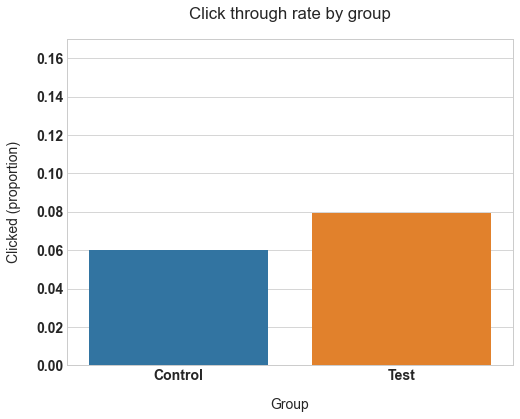

In [19]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['clicked'], ci=False)

plt.ylim(0, 0.17)
plt.title('Click through rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Clicked (proportion)', labelpad=15);

Let us plot the outputted distribution of the number of clicks of our two groups. We can model these distributions by the binomial distribution since the clicks have been produced as the outcome of a series of independent bernoulli trials.

In [20]:
control_click_count = int(click_through_rates[click_through_rates.group=='Control'].num_clicks)
test_click_count = int(click_through_rates[click_through_rates.group=='Test'].num_clicks)
control_click_rate = float(click_through_rates[click_through_rates.group=='Control'].click_through_rate)
test_click_rate = float(click_through_rates[click_through_rates.group=='Test'].click_through_rate)

Below we have the distribution of the number of clicks for our control group given the control click rate and the sample size. From the graph you can see that it is most likely for the number of click of the control group to come out between 120 and 190 clicks. The vertical blue line represents the number of clicks from the test group which is above 200 and so very unlikely to have come from the control group's distribution, but still not impossible.

Text(0, 0.5, 'Probability')

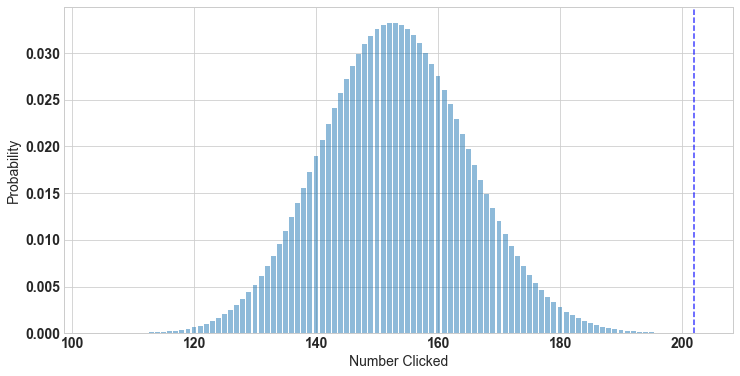

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
x_control = np.linspace(control_click_count-49, control_click_count+50, 100)
y_control = stats.binom.pmf(x_control,required_n,control_click_rate)
ax.bar(x_control, y_control, alpha=0.5)
ax.axvline(x=test_click_rate * required_n, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('Number Clicked')
plt.ylabel('Probability')

In the graph below we plot the distributions of both groups with the control group on the left and the test group on the right. We can see that whilst there is some overlap between the distributions they have a fairly distinct range of likely points.

Text(0, 0.5, 'Probability')

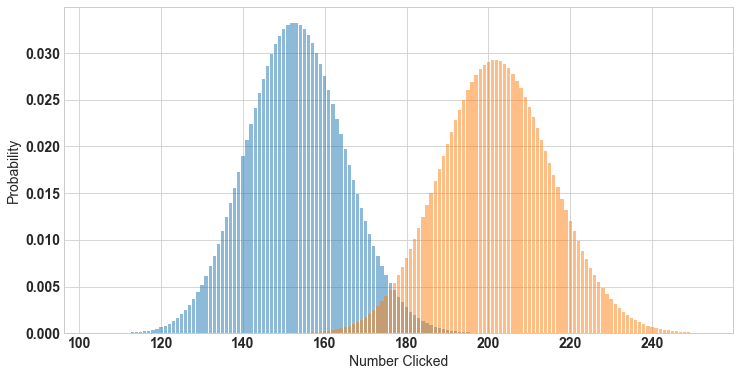

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
x_control = np.linspace(control_click_count-49, control_click_count+50, 100)
y_control = stats.binom.pmf(x_control,required_n,control_click_rate)
ax.bar(x_control, y_control, alpha=0.5)
x_test = np.linspace(test_click_count-49, test_click_count+50, 100)
y_test = stats.binom.pmf(x_test,required_n,test_click_rate)
ax.bar(x_test, y_test, alpha=0.5)
plt.xlabel('Number Clicked')
plt.ylabel('Probability')

From these graphs we can see that it is unlikely that our two distributions for the number of clicks have the same mean, but to investigate this formally we will have to look at and standardize our click through rates.To do this we will use the central limit theorem to approximate these distributions by the normal distribution. Since our click through rates were distributed by the bernoulli distribution we can calculate its mean and standard deviation to be used for the approximated normal distribtion.

In the graph below we plot the normal distributions obtained from the central limit theorem for each group. The vertical dashed line represents the mean click through rate for each group

Text(0, 0.5, 'PDF')

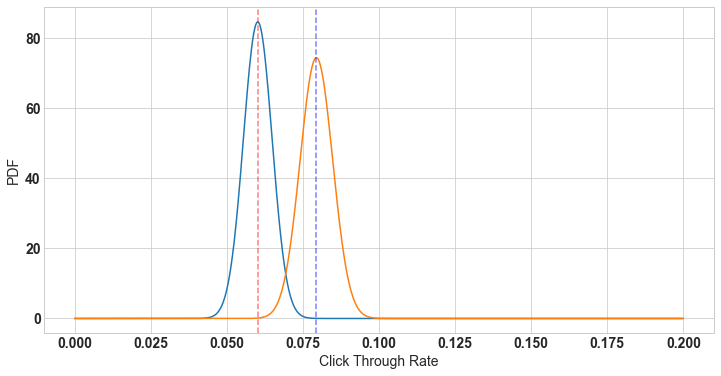

In [23]:
# standard error of the mean for both groups
SE_A = np.sqrt(control_click_rate * (1-control_click_rate)) / np.sqrt(required_n)
SE_B = np.sqrt(test_click_rate * (1-test_click_rate)) / np.sqrt(required_n)
# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, 0.2, 1000)
yA = stats.norm(control_click_rate, SE_A).pdf(xA)
ax.plot(xA, yA)
ax.axvline(x=control_click_rate, c='red', alpha=0.5, linestyle='--')
yB = stats.norm(test_click_rate, SE_B).pdf(xA)
ax.plot(xA, yB)
ax.axvline(x=test_click_rate, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Click Through Rate')
plt.ylabel('PDF')

Now for our null hypothesis we assume that the difference between the means of the two distributions is zero. Thus when we subtract the two normal distributions from each other we get a normal distribution with mean 0 and standard deviation being the square root of the sum of the variances.

Text(0, 0.5, 'PDF')

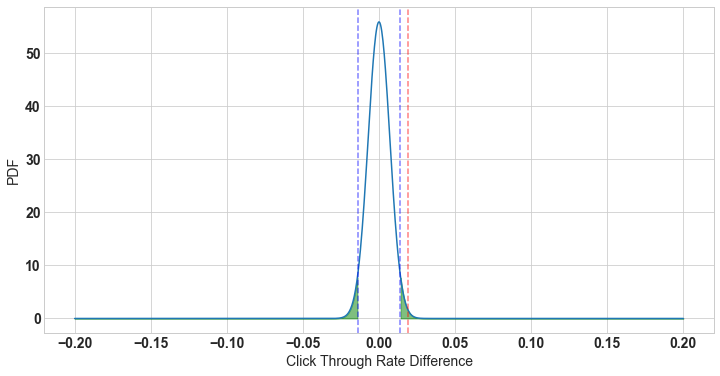

In [24]:
# standard error of the mean for both groups
SE = np.sqrt((control_click_rate * (1-control_click_rate))/required_n + (test_click_rate * (1-test_click_rate))/required_n)
# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(-0.2, 0.2, 1000)
y = stats.norm(0, SE).pdf(x)
ax.plot(x, y)
ax.axvline(x=stats.norm.interval(alpha=0.95, loc=0, scale=SE)[1], c='blue', alpha=0.5, linestyle='--')
ax.axvline(x=stats.norm.interval(alpha=0.95, loc=0, scale=SE)[0], c='blue', alpha=0.5, linestyle='--')
ax.axvline(x=test_click_rate-control_click_rate, c='red', alpha=0.5, linestyle='--')
ax.fill_between(x[x > stats.norm.interval(alpha=0.95, loc=0, scale=SE)[1]], np.zeros(sum(x > stats.norm.interval(alpha=0.95, loc=0, scale=SE)[1])), y[x > stats.norm.interval(alpha=0.95, loc=0, scale=SE)[1]], color='green', alpha=0.5)
ax.fill_between(x[x < stats.norm.interval(alpha=0.95, loc=0, scale=SE)[0]], np.zeros(sum(x < stats.norm.interval(alpha=0.95, loc=0, scale=SE)[0])), y[x < stats.norm.interval(alpha=0.95, loc=0, scale=SE)[0]], color='green', alpha=0.5)
plt.xlabel('Click Through Rate Difference')
plt.ylabel('PDF')

The shaded area above represents the significance level of the test alpha which is the probability of a false positive (accepting the alternative hypothesis incorrectly). In this case we are carrying out a two sided test to take into account unwanted adverse affects of decreasing the click through rate.

The red line above shows the value for the difference between the two click through rates from our data. Thus we will use the normal distribution with mean 0 calculated from our null hypothesis to test whether this difference was likely given that we assume that the mean difference is zero. Thus this will tell us whether this assumption was a good assumption to make. Visually you can see that the red line is outside of the bounds of the two blue lines showing the end regions of the test and so we can reject our null hypothesis that the difference between the means is not zero.

An alternative way to see this is by calculating the p value for the test as below and comparing it to 0.025 (as our alpha value is 0.05 and we are conducying a two way test)

In [25]:
1-stats.norm(0, SE).cdf(test_click_rate - control_click_rate)

0.0034838178142840848

Our p-value is less than 0.025 and so the difference of the two groups' means was statistically significant and we can reject the null hypothesis that the two means are equal. This means that the company is confident that their new visual for the show produces a higher click through rate than the old one and they can start rolling it out.